In [1]:
import sys
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from datetime import datetime
from itertools import combinations
from skopt import BayesSearchCV
from skopt.space import Real
from sklearn.model_selection import StratifiedKFold

In [2]:
logs = []
PARAMETROS = {
    'task_type' : 'GPU',
    'has_time' : True,
    'silent' : True,
    'iterations' : 10
}

In [3]:
#APERTURA ARCHIVOS
test = pd.read_pickle("Archivos/Arboles_validacion.pkl")

prediccion_arbol = pd.read_csv("Archivos/prediccion_arbol_validacion.csv")
prediccion_red   = pd.read_csv("Archivos/prediccion_neurona_validacion.csv")
prediccion_bayes = pd.read_csv("Archivos/prediccion_naive_bayes_val.csv")
prediccion_arbol_test = pd.read_csv("Archivos/prediccion_arbol_test.csv")
prediccion_red_test   = pd.read_csv("Archivos/prediccion_neurona_test.csv")
prediccion_bayes_test = pd.read_csv("Archivos/prediccion_naive_bayes.csv")

In [4]:
#AGRUPACION POR OPPORTUNITY_ID
prediccion_arbol = prediccion_arbol.groupby('Opportunity_ID').mean()
prediccion_arbol = prediccion_arbol.reset_index()
prediccion_red = prediccion_red.groupby('Opportunity_ID').mean()
prediccion_red = prediccion_red.reset_index()
prediccion_bayes = prediccion_bayes.groupby('Opportunity_ID').mean()
prediccion_bayes = prediccion_bayes.reset_index()

test = test.sort_values('Opportunity_ID')
test = test.groupby('Opportunity_ID').mean()
test = test.reset_index()
test_label = test['Stage']

In [5]:
#ORDENO ARCHIVOS PARA QUE COINCIDA OPPORTUNITY_ID
test = test.sort_values('Opportunity_ID')
prediccion_arbol = prediccion_arbol.sort_values('Opportunity_ID')
prediccion_red   = prediccion_red.sort_values('Opportunity_ID')
prediccion_bayes = prediccion_bayes.sort_values('Opportunity_ID')
prediccion_arbol_test = prediccion_arbol_test.sort_values('Opportunity_ID')
prediccion_red_test   = prediccion_red_test.sort_values('Opportunity_ID')
prediccion_bayes_test = prediccion_bayes_test.sort_values('Opportunity_ID')

test_label = test['Stage']

In [6]:
prediccion_red.count()

Opportunity_ID    2618
Target            2618
dtype: int64

In [7]:
prediccion_arbol.count()

Opportunity_ID    2618
Target            2618
dtype: int64

In [8]:
prediccion_bayes.count()

Opportunity_ID    2618
Target            2618
dtype: int64

In [9]:
prediccion_red.head(5)

,Opportunity_ID,Target
0,7042,0.817983
1,7043,0.729509
2,7044,0.177205
3,7045,0.797719
4,7046,0.454581


In [10]:
prediccion_arbol.head(5)

,Opportunity_ID,Target
0,7042,0.644573
1,7043,0.629712
2,7044,0.058727
3,7045,0.855208
4,7046,0.612680


In [11]:
prediccion_bayes.head(5)

,Opportunity_ID,Target
0,7042,0.661839
1,7043,0.661838
2,7044,0.661838
3,7045,0.661838
4,7046,0.661838


In [12]:
#CREACION DE VARIABLES COMUNES A LOS MODELOS
macro_entrenamiento = pd.DataFrame()
macro_entrenamiento['Arbol'] = prediccion_arbol['Target']
macro_entrenamiento['Bayes'] = prediccion_bayes['Target']
macro_entrenamiento['Red'] = prediccion_red['Target']
macro_entrenamiento['Stage'] = test_label
entrenamiento = macro_entrenamiento.iloc[:int(len(macro_entrenamiento)/2),:]
validacion = macro_entrenamiento.iloc[int(len(macro_entrenamiento)/2) + 1:,:]
entrenamiento_label = entrenamiento.pop('Stage')

macro_test = pd.DataFrame()
macro_test['Arbol'] = prediccion_arbol_test['Target']
macro_test['Bayes'] = prediccion_bayes_test['Target']
macro_test['Red'] = prediccion_red_test['Target']

In [13]:
#Datos para el gráfico
logs.append(("Árboles", skl.metrics.log_loss(test_label,prediccion_arbol['Target'])))
logs.append(("Red neuronal", skl.metrics.log_loss(test_label,prediccion_red['Target'])))
logs.append(("Bayes", skl.metrics.log_loss(test_label,prediccion_bayes['Target'])))

In [14]:
#MODELOS PARTICULARES

#Max
def ensamble_max():
    preds = macro_entrenamiento.drop(columns=['Stage']).max(axis=1)
    print('Logloss Max: ', skl.metrics.log_loss(test_label,preds))
    logs.append(("Max",skl.metrics.log_loss(test_label,preds)))
    preds = macro_test.max(axis=1)
    return preds

#Min
def ensamble_min():
    preds = macro_entrenamiento.drop(columns=['Stage']).min(axis=1)
    print('Logloss Min: ', skl.metrics.log_loss(test_label,preds))
    logs.append(("Min",skl.metrics.log_loss(test_label,preds)))
    preds = macro_test.min(axis=1)
    return preds

#Combinacion lineal
def ensamble_cl():
    min_a = -1
    min_b = -1
    min_c = -1
    min_logloss = 1000

    for a in range(0,10):
        for b in range(0,10):
            for c in range(0,10):
                if(a == 0 & b == 0 & c == 0): continue
                preds = (a*prediccion_arbol['Target'] + b*prediccion_red['Target'] + c*prediccion_bayes['Target'])/(a+b+c)
                logloss = skl.metrics.log_loss(test_label,preds)
                if(logloss < min_logloss):
                    min_logloss = logloss
                    min_a = a
                    min_b = b
                    min_c = c
    print("Logloss  CL:  %.16f (min_a : %i, min_b: %i, min_c : %i)"% (min_logloss, min_a, min_b, min_c))
    logs.append(("Combinacion Lineal",min_logloss))
    preds = (min_a*prediccion_arbol_test['Target'] + min_b*prediccion_red_test['Target']
             + min_c*prediccion_bayes_test['Target'])/(min_a+min_b+min_c)
    return preds

In [15]:
#MODELOS GENERALES

def generar_preds_ensamble(clasificador, msg, nombre):
    clasificador.fit(entrenamiento, entrenamiento_label)
    preds = clasificador.predict_proba(validacion.drop(columns=['Stage']))
    print(msg, skl.metrics.log_loss(validacion['Stage'],preds))
    logs.append((nombre, skl.metrics.log_loss(validacion['Stage'],preds)))

    clasificador.fit(macro_entrenamiento.drop(columns=['Stage']), macro_entrenamiento['Stage'])
    preds = clasificador.predict_proba(macro_test)
    preds = pd.Series([p[1] for p in preds])
    return preds

#KNN
def ensamble_knn(): return generar_preds_ensamble(KNeighborsClassifier(n_neighbors=300), "Logloss KNN: ","KNN")

#Catboost
def ensamble_catboost(): return generar_preds_ensamble(cb.CatBoostClassifier(**PARAMETROS), "Logloss Cat: ","Catboost")

#Naive Bayes
def ensamble_naive_bayes(): return generar_preds_ensamble(GaussianNB(var_smoothing =0.5), "Log   Bayes: ","Bayes")

#Support Vector Classification
def ensamble_svc(): return generar_preds_ensamble(SVC(probability = True), "Logloss SVC: ","SVC")

#Regresion Logística
def ensamble_rl(): return generar_preds_ensamble(skl.linear_model.LogisticRegression(), "Logloss  RL: ","Regresión Logística")

In [16]:
#CALCULO Y SELECCION DE PREDS
print("Logloss Árboles: ",skl.metrics.log_loss(test_label,prediccion_arbol['Target']))
print("Logloss Redes:   ", skl.metrics.log_loss(test_label,prediccion_red['Target']))
print("Logloss Bayes:   ", skl.metrics.log_loss(test_label,prediccion_bayes['Target']))
print("")

preds_max = ensamble_max()
preds_min = ensamble_min()
preds_cl  = ensamble_cl()
preds_rl = ensamble_rl()
preds_knn = ensamble_knn()
preds_catboost = ensamble_catboost()
preds_bayes = ensamble_naive_bayes()
preds_svc = ensamble_svc()

Logloss Árboles:  0.4212679100075896
Logloss Redes:    0.5213569467486834
Logloss Bayes:    0.6912080878061103

Logloss Max:  0.6099612685101373
Logloss Min:  0.5272506681769829
Logloss  CL:  0.4212679100075896 (min_a : 1, min_b: 0, min_c : 0)
Logloss  RL:  0.3972305935461217
Logloss KNN:  0.4045222063190072
Logloss Cat:  0.39815475745133766
Log   Bayes:  0.41706875789157716
Logloss SVC:  0.4253391342113072


In [17]:
#GUARDADO DE ARCHIVOS
preds = preds_catboost
resultados = pd.DataFrame()
resultados['Opportunity_ID'] = prediccion_arbol_test['Opportunity_ID']
resultados['Target'] = pd.Series(preds)  
resultados.to_csv("Archivos/prediccion.csv", index=False)

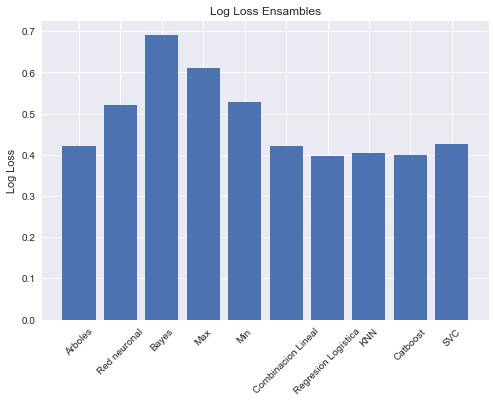

In [20]:
from matplotlib import style
plt.bar([i[0] for i in logs],[i[1] for i in logs])
plt.title("Log Loss Ensambles")
plt.ylabel("Log Loss")
plt.xticks(rotation=45)
style.use("seaborn")
plt.show()

In [19]:
fallar

NameError: name 'fallar' is not defined

In [ ]:
#REFINAMIENTO DE CATBOOST

# Classifier
bayes_cv_tuner = BayesSearchCV(
estimator = cb.CatBoostClassifier(
silent=True,task_type="GPU"
),
search_spaces = {
        "iterations" : (2, 100),
        'learning_rate': Real(low=0.01, high=1, prior='log-uniform'),
        "random_seed" : (1,40000),
        "l2_leaf_reg" : Real(low=1e-9, high=1000, prior='log-uniform'),
        #'subsample': Real(low=0.01, high=1, prior='uniform'),
        "random_strength" : Real(low=1e-9, high=1000, prior='log-uniform'),
        'depth': (1, 10),
        "early_stopping_rounds" : (1, 5),
        "border_count" : (1,65535),
        "bagging_temperature" : Real(low=1e-9,high=1000,prior='log-uniform'),
        "scale_pos_weight" : Real(low = 0.01,high = 1.0,prior="uniform")
},
cv = skl.model_selection.TimeSeriesSplit(),
n_jobs = 1,
n_iter = 6,
verbose = 1,
refit = True,
random_state = 72
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    

    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
resultCAT = bayes_cv_tuner.fit(entrenamiento, entrenamiento_label, callback=status_print)